In [1]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from dataloader.gen_dataloader import generate_test_dataloader_dual_cnn_stream_for_kfold

test_dir = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/CAM/data2"
test_loader = generate_test_dataloader_dual_cnn_stream_for_kfold(test_dir, 128, 1, 4, adj_brightness=1.0, adj_contrast=1.0, highpass=None)


import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model

class CrossAttention(nn.Module):
    def __init__(self, in_dim, inner_dim=0, prj_out=False, qkv_embed=True, init_weight=True):
        super(CrossAttention, self).__init__()
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.init_weight = init_weight
        self.to_out = nn.Identity()
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()

        if self.init_weight:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.xavier_normal_(m.weight.data, gain=0.02)

    def forward(self, x, y, z):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(x)
            k = self.to_k(y)
            v = self.to_v(z)
        else:
            q, k, v = x, y, z
        out, attn = self.scale_dot(q, k, v, dropout_p=0.00)
        out = self.to_out(out)
        return out, attn

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

class DualCNNViT(nn.Module):
    def __init__(self, image_size=224, num_classes=1, dim=1024,\
                depth=6, heads=8, mlp_dim=2048,\
                dim_head=64, dropout=0.15,\
                backbone='xception_net', pretrained=True,\
                normalize_ifft='batchnorm',\
                flatten_type='patch',\
                conv_attn=False, ratio=5, qkv_embed=True, init_ca_weight=True, prj_out=False, inner_ca_dim=512, act='none',\
                patch_size=7, \
                version='ca-fcat-0.5', unfreeze_blocks=-1, \
                init_weight=False, init_linear="xavier", init_layernorm="normal", init_conv="kaiming", \
                dropout_in_mlp=0.0, classifier='mlp'):  
        super(DualCNNViT, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        
        self.backbone = backbone
        self.features_size = {
            'efficient_net': (1280, 4, 4),
            'xception_net': (2048, 4, 4),
        }
        self.out_ext_channels = self.features_size[backbone][0]
        
        self.flatten_type = flatten_type # in ['patch', 'channel']
        self.version = version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.conv_attn = conv_attn
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[self.backbone])
        ############################# PATCH CONFIG ################################
        
        if self.flatten_type == 'patch':
            # Kích thước của 1 patch
            self.patch_size = patch_size
            # Số lượng patches
            self.num_patches = int((self.features_size[backbone][1] * self.features_size[backbone][2]) / (self.patch_size * self.patch_size))
            # Patch_dim = P^2 * C
            self.patch_dim = self.out_ext_channels//ratio * (self.patch_size ** 2)

        ############################# CROSS ATTENTION #############################
        if self.flatten_type == 'patch':
            self.in_dim = self.patch_dim
        else:
            self.in_dim = int(self.features_size[backbone][1] * self.features_size[backbone][2])
        if self.conv_attn:
            self.query_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.key_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.value_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)

        self.CA = CrossAttention(in_dim=self.in_dim, inner_dim=inner_ca_dim, prj_out=prj_out, qkv_embed=qkv_embed, init_weight=init_ca_weight)

        ############################# VIT #########################################
        # Giảm chiều vector sau concat 2*patch_dim về D:
        if 'cat' in self.version:
            self.embedding = nn.Linear(2 * self.in_dim, self.dim)
        else:
            self.embedding = nn.Linear(self.in_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.classifier = classifier
        self.num_vecs = self.num_patches if self.flatten_type == 'patch' else self.out_ext_channels//ratio
        if 'vit' in self.classifier:
            self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
            self.batchnorm = nn.BatchNorm1d(self.num_vecs)
        if 'vit_aggregate' in self.classifier:
            gamma = float(self.classifier.split('_')[-1])
            if gamma == -1:
                self.gamma = nn.Parameter(torch.ones(1))
            else:
                self.gamma = gamma

        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_head_hidden = nn.Linear(self.dim, self.mlp_dim)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_out = nn.Linear(self.mlp_dim, self.num_classes)
        self.sigmoid = nn.Sigmoid()
        self.init_linear, self.init_layernorm, self.init_conv = init_linear, init_layernorm, init_conv
        if init_weight:
            self.apply(self._init_weights)

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'leakyrely':
            activation = nn.LeakyReLU()
        elif act == 'selu':
            activation = nn.SELU()
        elif act == 'gelu':
            activation = nn.GELU()
        else:
            activation = None
        return activation

    def init_conv_weight(self, module):
        for ly in module.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None:
                    nn.init.constant_(ly.bias, 0)
            elif isinstance(ly, nn.Module):
                self.init_conv_weight(ly)

    def init_transformer_weights(self, module):
        if isinstance(module, nn.Linear):
            print("Linear: ", module)
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            print("Layer norm: ", module)
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # print("Linear: ", module)
            if self.init_linear == 'normal':
                module.weight.data.normal_(mean=0.0, std=1.0)
            elif self.init_linear == 'xavier':
                nn.init.xavier_uniform_(module.weight)
            else:
                pass
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            # print("Layer norm: ", module)
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, nn.Conv2d) and self.pretrained == 0:
            # print("Conv: ", module)
            if self.init_conv == 'kaiming':
                nn.init.kaiming_normal_(module.weight, a=1)
            elif self.init_conv == "xavier":
                nn.init.xavier_uniform_(module.weight)
            else:
                pass

            if not module.bias is None:
                nn.init.constant_(module.bias, 0)

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        # if not pretrained:
        #     self.init_conv_weight(extractor)
        return extractor

    def flatten_to_vectors(self, feature):
        vectors = None
        if self.flatten_type == 'patch':
            vectors = rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(feature, 'b c h w -> b c (h w)')
        else:
            pass
        return vectors

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, rgb):
        return self.rgb_extractor.extract_features(rgb)

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            #
            # hook = 11
            # x = self.rgb_extractor.extract_features_at_block(rgb_imgs, hook)
            # h = x.register_hook(self.activations_hook)

            # print("x ", x.shape)
            
            # rgb_features = self.rgb_extractor.extract_features_to_lastblock(x, hook+1)                 # shape (batchsize, 1280, 8, 8)
            # freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)

            rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
            
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        rgb_features.register_hook(self.activations_hook)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        # Turn to q, k, v if use conv-attention, and then flatten to vector:
        if self.conv_attn:
            rgb_query = self.query_conv(rgb_features)
            freq_value = self.value_conv(freq_features)
            ifreq_key = self.key_conv(ifreq_features)
            ifreq_value = self.value_conv(ifreq_features)
        else:
            rgb_query = rgb_features
            freq_value = freq_features
            ifreq_key = ifreq_features
            ifreq_value = ifreq_features
        # print("Q K V shape: ", rgb_query.shape, freq_value.shape, ifreq_key.shape, ifreq_value.shape)
        rgb_query_vectors = self.flatten_to_vectors(rgb_query)
        freq_value_vectors = self.flatten_to_vectors(freq_value)
        ifreq_key_vectors = self.flatten_to_vectors(ifreq_key)
        ifreq_value_vectors = self.flatten_to_vectors(ifreq_value)
        # print("Vectors shape: ", rgb_query_vectors.shape, freq_value_vectors.shape, ifreq_key_vectors.shape, ifreq_value_vectors.shape)

        ##### Cross attention and fusion:
        out, attn_weight = self.CA(rgb_query_vectors, ifreq_key_vectors, ifreq_value_vectors)
        attn_out = torch.bmm(attn_weight, freq_value_vectors)
        fusion_out = self.fusion(rgb_query_vectors, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        # print("Fusion shape: ", fusion_out.shape)
        embed = self.embedding(fusion_out)
        # print("Inner ViT shape: ", embed.shape)

        ##### Forward to ViT
        if self.classifier == 'mlp':
            x = embed.mean(dim = 1).squeeze(dim=1)     # B, N, D => B, 1, D
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)

        if self.classifier == 'vit':
            x = self.transformer(embed)
            # sys.stdout = open('/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/check.txt', 'w')
            # print(x[0])
            # sys.stdout = sys.__stdout__
            x = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)

        if 'vit_aggregate' in self.classifier:
            x = self.transformer(embed)
            # x = self.batchnorm(x)    
            x = embed + self.gamma * x
            x = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)
        x = self.sigmoid(x)
        return x

model = DualCNNViT(  image_size=128, num_classes=1, dim=1024,\
                        depth=1, heads=3, mlp_dim=2048,\
                        dim_head=64, dropout=0.15, \
                        backbone='efficient_net', pretrained=False,\
                        normalize_ifft="batchnorm",\
                        flatten_type='patch',\
                        conv_attn=False, ratio=1, qkv_embed=True, inner_ca_dim=0, init_ca_weight=False, prj_out=False, act='selu',\
                        patch_size=2, \
                        version='ca-fadd-0.8', unfreeze_blocks=-1, classifier='vit_aggregate_0.3')

checkpoint = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/checkpoint/datasetv5/dfdcv5/kfold_dual_cnn_vit/lr0.0003-0_b32_esnone_lbce_nf5_trick1_clsvit_aggregate_0.3_v_ca-fadd-0.8_d1024_md2048_h3_d1_pcls_bbefficient_net_pre1_unf-1_normbatchnorm_fpatch_pat2_conv0_r1_qkv1_cad0_prj0_actselu_seed0_drmlp0.3_aug0/(0.1717_0.9393_0.3825_0.8667)_fold_2/step/best_test_acc_107000_0.866685.pt"
model.load_state_dict(torch.load(checkpoint))

/mnt/disk1/anaconda3/envs/phucnp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


fft dual test len:  1
Pretrained backbone:  False
Pretrained backbone:  False


<All keys matched successfully>

In [2]:
c = 192
h = 11

tensor([[1.]], grad_fn=<SigmoidBackward>)


/mnt/disk1/anaconda3/envs/phucnp/lib/python3.8/site-packages/torch/autograd/__init__.py:145: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:219.)
  Variable._execution_engine.run_backward(


<Figure size 1440x1440 with 0 Axes>

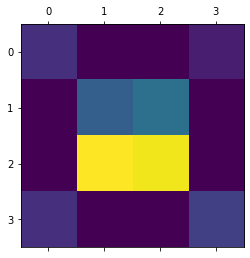

In [3]:
model.eval()
rgb, freq, _ = next(iter(test_loader))
rgb, freq = rgb.float(), freq.float()
pred = model(rgb, freq)
print(pred)

pred[:, 0].backward()
# pull the gradients out of the model
gradients = model.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = model.get_activations(rgb).detach()

# weight the channels by corresponding gradients
for i in range(c):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

from PIL import Image
plt.figure(figsize=(20, 20))

# draw the heatmap
plt.matshow(heatmap.squeeze())
# plt.title('heatmap image ')

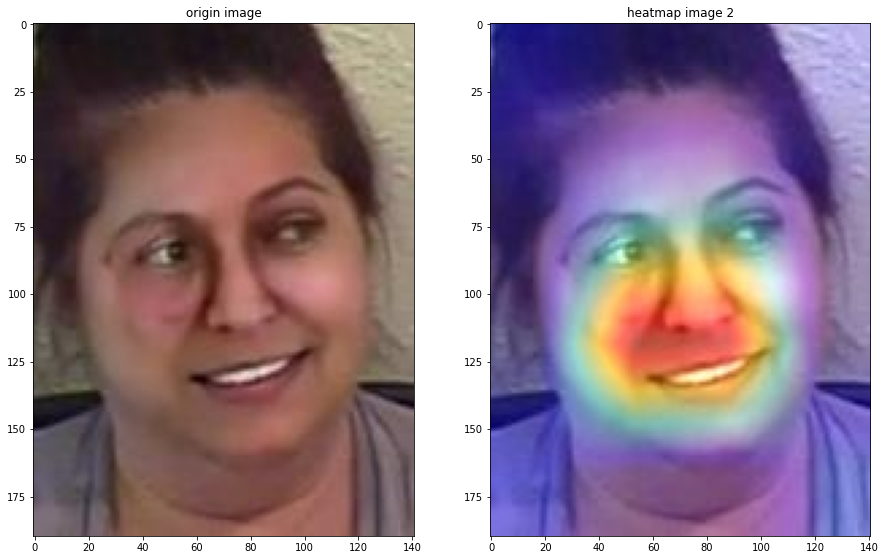

In [4]:
#
import cv2
img = cv2.imread('/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/CAM/data2/1_df/6.jpg')
heatmap = heatmap.cpu().detach().numpy()
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map_{}.jpg'.format(0), superimposed_img)

ori_image = Image.open("/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/CAM/data2/1_df/6.jpg")
img = Image.open('./map_{}.jpg'.format(0))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(ori_image)
plt.title('origin image')
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title('heatmap image 2')
plt.show()